# Implement RULES to extract related adjectives then Implement visualization 

# SETUP

In [21]:
import pandas as pd
import numpy as np
import nltk
import time
import spacy
import pickle
sp_md = spacy.load('en_core_web_md')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

# Load data


In [2]:
wdir="steam/"
wdir="metacritic/"
wdir="AM_videogames/"
df = pd.read_pickle(wdir+"1_df.pkl")
print(df.shape)
print(df.groupby('game_title').review_id.nunique())
df = df.sample(frac=1).reset_index(drop=True) # random sampling and resetting index

df.head(1)

(2585, 4)
game_title
God of War III                    601
Mario Kart                        472
StarCraft II: Wings of Liberty    370
The Last of Us                    549
diablo III                        593
Name: review_id, dtype: int64


,review_id,game_title,review_text,score
0,65133,God of War III,I don't think I have ever seen a video game of...,4.0


# Preprocessing reviews

## split reviews in sentences + compute sentence polarities

In [3]:
from nltk import tokenize # del
from sentiment_polarity import * 
# nltk.download('punkt') # doesnt re download is exists ) 
from stopwords import *

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Quentin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# %%timeit -n 1 -r 1 
sentences_df = extract_sentences(df)


sentences_df['vader_polarity'] = sentences_df["sentence"].apply(getVaderPolarity)


print(sentences_df.shape)
sentences_df.to_pickle(wdir+"2_df.pkl")

# sentences_df.head(1)

2585
100% processed     
(15252, 4)


## Stop words


In [5]:
# %%timeit -n 1 -r 1 # number of loop
sentences_df = pd.read_pickle(wdir+"2_df.pkl")

games_list=df['game_title'].unique()

proc_sent_df = remove_stop_prefixes(sentences_df,games_list)
print(proc_sent_df.shape)


proc_sent_df.to_pickle(wdir+"3_df.pkl")
proc_sent_df.head()
games_list

100% processed       % processed    % processed    % processed
(15252, 5)


array(['Mario Kart', 'God of War III', 'StarCraft II: Wings of Liberty',
       'The Last of Us', 'diablo III'], dtype=object)

## POS + Lemmatization
TB and WN, 30 sec for 20k sentences
SP is way longer, 60x longer (30 min )




In [6]:
from POSLemma import *

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\basil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\basil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\basil\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [7]:
# # %%timeit -n 1 -r 1 # number of loop
# POSLemmaChoice ="SP" # WN TB SP
# proc_sent_df = pd.read_pickle(wdir+"3_df.pkl")


# POSLemma_sent_df = POSLemma_extractor(proc_sent_df,POSLemmaChoice)


# ## Save POSLemma Dataframe
# POSLemma_sent_df.to_pickle(wdir+"4_"+POSLemmaChoice+"_df.pkl")
# print(POSLemma_sent_df.head(5))
# print(POSLemma_sent_df.shape)

# Create FOPs and compute importance

## FOPs extraction

In [6]:
from FOPs import * 

In [7]:
# %%timeit -n 1 -r 1 # number of loop
"""
input: Dataframe of sentences with POS tags, chosen POS method and game title. 
Output: a dictionary of FOPs with their occurence and importance(occurence*sentence polarity) , structured as: 
        {"feature1": 
            {"opinion1": 
                { "count": value, 
                "importance":value } }
            {"opinion2": 
                { "count": value, 
                "importance":value } }
"""

POSLemmaChoice="SP"
FOPs_df = pd.read_pickle(wdir+"4_"+POSLemmaChoice+"_df.pkl")
# print(FOPs_df.groupby('game_title').review_id.nunique())
games_list=df['game_title'].unique()
print(games_list)
chosen_game="diablo III"


FOPs_game_dic = extract_all_FOPs(FOPs_df, chosen_game)

save_FOPs_dic_csv(FOPs_game_dic, wdir,chosen_game )


['God of War III' 'StarCraft II: Wings of Liberty' 'The Last of Us'
 'diablo III' 'Mario Kart']
4864  sentences for the game  diablo III


## count and importance FOPs results
Can also select only negatives or only positive, select specific feature(s)

In [8]:
FOPs_df = pd.read_csv(wdir+chosen_game+"_FOPs.csv")  # Creation of the dataframe 

FOPs_df["count"] = FOPs_df["count"]/2
FOPs_df["importance"] = FOPs_df["importance"]/2
FOPs_df["importance"] = FOPs_df["importance"]/FOPs_df["importance"].max()
FOPs_df["polarity"] = FOPs_df["importance"]/FOPs_df["count"]
FOPs_df["importance"]= abs(FOPs_df["importance"])
FOPs_df = FOPs_df.sort_values('importance', ascending=False)
FOPs_df=FOPs_df.reset_index(drop=True)
# maxCount = FOPs_df.iloc[0]["count"]
# FOPs_df = FOPs_df.loc[FOPs_df["count"] > maxCount/20]
# FOPs_df = FOPs_df.sort_values('importance', ascending=False)
print(FOPs_df.shape)
FOPs_df.head(20)

(22863, 5)


,feature,opinion,count,importance,polarity
0,items,lettered,22.0,1.000000,0.045455
1,fun,farm,9.0,0.677493,-0.075277
2,items,better,11.0,0.640998,0.058273
3,slash,bang,9.0,0.460610,-0.051179
4,auction,good,10.0,0.456262,0.045626
5,time,good,8.0,0.456199,0.057025
6,fun,act,6.0,0.451662,-0.075277
7,growth,farm,6.0,0.451662,-0.075277
8,fun,shotted,6.0,0.451662,-0.075277
9,inferno,farm,6.0,0.451662,-0.075277


In [9]:
FOPs_df = FOPs_df.sort_values('count', ascending=False)
FOPs_df=FOPs_df.reset_index(drop=True)

FOPs_df.head(5)

,feature,opinion,count,importance,polarity
0,player,single,51.0,0.345264,-0.006770
1,money,real,39.0,0.017833,-0.000457
2,auction,real,28.0,0.120917,-0.004318
3,house,real,26.0,0.108702,-0.004181
4,items,lettered,22.0,1.000000,0.045455


In [10]:
sentence="The sound of the speakers could be better"
def FOP_parser_sentence(sentence,sp_md,FOPs_game_dic):
    prod_pronouns=["it", "they", "this"]
    doc=sp_md(sentence)
    #print("--- SPACY : Doc loaded ---")

    ## FIRST RULE OF DEPENDANCY PARSE -
    ## M - Sentiment modifier || A - Aspect
    ## RULE = M is child of A with a relationshio of amod
    rule1_pairs = []
    rule2_pairs = []
    rule3_pairs = []
    rule4_pairs = []
    rule5_pairs = []
    rule6_pairs = []

    for token in doc:
        A = "999999"
        M = "999999"
        if token.dep_ == "amod" and not token.is_stop:
            M = token.text
            A = token.head.text

            # add adverbial modifier of adjective (e.g. 'most comfortable headphones')
            M_children = token.children
            for child_m in M_children:
                if(child_m.dep_ == "advmod"):
                    M_hash = child_m.text
                    M = M_hash + " " + M
                    break

            # negation in adjective, the "no" keyword is a 'det' of the noun (e.g. no interesting characters)
            A_children = token.head.children
            Msent=M
            for child_a in A_children:
                if(child_a.dep_ == "det" and child_a.text == 'no'):
                    neg_prefix = 'not'
                    Msent = neg_prefix + " " + M
                    break

        if(A != "999999" and M != "999999"):
            if A in prod_pronouns :
                A = "product"
            dict1 = {"noun" : A, "adj" : M, "rule" : 1, "polarity" : getVaderPolarity(Msent)}
            rule1_pairs.append(dict1)

        # print("--- SPACY : Rule 1 Done ---")

        # # SECOND RULE OF DEPENDANCY PARSE -
        # # M - Sentiment modifier || A - Aspect
        # Direct Object - A is a child of something with relationship of nsubj, while
        # M is a child of the same something with relationship of dobj
        # Assumption - A verb will have only one NSUBJ and DOBJ
        children = token.children
        A = "999999"
        M = "999999"
        add_neg_pfx = False
        for child in children :
            if(child.dep_ == "nsubj" and not child.is_stop):
                A = child.text
                # check_spelling(child.text)

            if((child.dep_ == "dobj" and child.pos_ == "ADJ") and not child.is_stop):
                M = child.text
                #check_spelling(child.text)

            if(child.dep_ == "neg"):
                neg_prefix = child.text
                add_neg_pfx = True
        Msent=M
        if (add_neg_pfx and M != "999999"):
            Msent = neg_prefix + " " + M
        
        if(A != "999999" and M != "999999"):
            if A in prod_pronouns :
                A = "product"
            dict2 = {"noun" : A, "adj" : M, "rule" : 2, "polarity" : getVaderPolarity(Msent)}
            rule2_pairs.append(dict2)




        # print("--- SPACY : Rule 2 Done ---")

        ## THIRD RULE OF DEPENDANCY PARSE -
        ## M - Sentiment modifier || A - Aspect
        ## Adjectival Complement - A is a child of something with relationship of nsubj, while
        ## M is a child of the same something with relationship of acomp
        ## Assumption - A verb will have only one NSUBJ and DOBJ
        ## "The sound of the speakers would be better. The sound of the speakers could be better" - handled using AUX dependency

        children = token.children
        A = "999999"
        M = "999999"
        add_neg_pfx = False
        for child in children :
            if(child.dep_ == "nsubj" and not child.is_stop):
                A = child.text
                # check_spelling(child.text)

            if(child.dep_ == "acomp" and not child.is_stop):
                M = child.text

            # example - 'this could have been better' -> (this, not better)
            if(child.dep_ == "aux" and child.tag_ == "MD"):
                neg_prefix = "not"
                add_neg_pfx = True

            if(child.dep_ == "neg"):
                neg_prefix = child.text
                add_neg_pfx = True
        Msent=M
        if (add_neg_pfx and M != "999999"):
            Msent = neg_prefix + " " + M
                #check_spelling(child.text)

        if(A != "999999" and M != "999999"):
            if A in prod_pronouns :
                A = "product"
            dict3 = {"noun" : A, "adj" : M, "rule" : 3, "polarity" : getVaderPolarity(Msent)}
            rule3_pairs.append(dict3)
            #rule3_pairs.append((A, M, getVaderPolarity(M),3))
    # print("--- SPACY : Rule 3 Done ---")

        ## FOURTH RULE OF DEPENDANCY PARSE -
        ## M - Sentiment modifier || A - Aspect

        #Adverbial modifier to a passive verb - A is a child of something with relationship of nsubjpass, while
        # M is a child of the same something with relationship of advmod

        #Assumption - A verb will have only one NSUBJ and DOBJ

        children = token.children
        A = "999999"
        M = "999999"
        add_neg_pfx = False
        for child in children :
            if((child.dep_ == "nsubjpass" or child.dep_ == "nsubj") and not child.is_stop):
                A = child.text
                # check_spelling(child.text)

            if(child.dep_ == "advmod" and not child.is_stop):
                M = child.text
                M_children = child.children
                for child_m in M_children:
                    if(child_m.dep_ == "advmod"):
                        M_hash = child_m.text
                        M = M_hash + " " + child.text
                        break
                #check_spelling(child.text)

            if(child.dep_ == "neg"):
                neg_prefix = child.text
                add_neg_pfx = True
        
        Msent=M
        if (add_neg_pfx and M != "999999"):
            Msent = neg_prefix + " " + M

        if(A != "999999" and M != "999999"):
            if A in prod_pronouns :
                A = "product"
            dict4 = {"noun" : A, "adj" : M, "rule" : 4, "polarity" : getVaderPolarity(Msent)}
            rule4_pairs.append(dict4)
            #rule4_pairs.append((A, M,getVaderPolarity(M),4)) # )

    # print("--- SPACY : Rule 4 Done ---")


        ## FIFTH RULE OF DEPENDANCY PARSE -
        ## M - Sentiment modifier || A - Aspect

        #Complement of a copular verb - A is a child of M with relationship of nsubj, while
        # M has a child with relationship of cop

        #Assumption - A verb will have only one NSUBJ and DOBJ

        children = token.children
        A = "999999"
        buf_var = "999999"
        for child in children :
            if(child.dep_ == "nsubj" and not child.is_stop):
                A = child.text
                # check_spelling(child.text)

            if(child.dep_ == "cop" and not child.is_stop):
                buf_var = child.text
                #check_spelling(child.text)

        if(A != "999999" and buf_var != "999999"):
            if A in prod_pronouns :
                A = "product"
            dict5 = {"noun" : A, "adj" : token.text, "rule" : 5, "polarity" : getVaderPolarity(M)}
            rule5_pairs.append(dict5)
            #rule5_pairs.append((A, token.text,getVaderPolarity(token.text),5))

    # print("--- SPACY : Rule 5 Done ---")

        ## SIXTH RULE OF DEPENDANCY PARSE -
        ## M - Sentiment modifier || A - Aspect
        ## Example - "It ok", "ok" is INTJ (interjections like bravo, great etc)

        children = token.children
        A = "999999"
        M = "999999"
        if(token.pos_ == "INTJ" and not token.is_stop):
            for child in children :
                if(child.dep_ == "nsubj" and not child.is_stop):
                    A = child.text
                    M = token.text
                    # check_spelling(child.text)

            #rule6_pairs.append((A, M,getVaderPolarity(M),6))

    # print("--- SPACY : Rule 6 Done ---")

    ## SEVENTH RULE OF DEPENDANCY PARSE -
    ## M - Sentiment modifier || A - Aspect
    ## ATTR - link between a verb like 'be/seem/appear' and its complement
    ## Example: 'this is garbage' -> (this, garbage)

        children = token.children
        A = "999999"
        M = "999999"
        add_neg_pfx = False
        for child in children :
            if(child.dep_ == "nsubj" and not child.is_stop):
                A = child.text
                # check_spelling(child.text)

            if((child.dep_ == "attr") and not child.is_stop):
                M = child.text
                #check_spelling(child.text)
            
            if(child.dep_ == "neg"):
                neg_prefix = child.text
                add_neg_pfx = True
        
        Msent=M
        if (add_neg_pfx and M != "999999"):
            M = neg_prefix + " " + M

        if(A != "999999" and M != "999999"):
            if A in prod_pronouns :
                A = "product"
            dict6 = {"noun" : A, "adj" : M, "rule" : 6, "polarity" : getVaderPolarity(Msent)}
            rule6_pairs.append(dict6)
            #rule7_pairs.append((A, M,getVaderPolarity(M),7))



    #print("--- SPACY : Rules Done ---")


    aspects = []

    aspects = rule1_pairs + rule2_pairs + rule3_pairs +rule4_pairs +rule5_pairs + rule6_pairs

    # replace all instances of "it", "this" and "they" with "product"
    #aspects = [(A,M,P,r) if A not in prod_pronouns else ("product",M,P,r) for A,M,P,r in aspects ]

    # dic = {"review_id" : review_id , "aspect_pairs" : aspects, "review_marketplace" : review_marketplace
    # , "customer_id" : customer_id, "product_id" : product_id, "product_parent" : product_parent,
    # "product_title" : product_title, "product_category" : product_category, "date" : date, "star_rating" : star_rating, "url" : url}
    
    for aspect in aspects:
        feature=aspect["noun"].lower()
        opinion=aspect["adj"].lower() 
        opinion=opinion.split(" ")
        opinion= "_".join(opinion)
        polarity= aspect["polarity"]

    # Count FOPs and weighted importance
        if feature not in FOPs_game_dic:
            FOPs_game_dic[feature]={} 

        if opinion not in FOPs_game_dic[feature]:
            FOPs_game_dic[feature][opinion]={}
            FOPs_game_dic[feature][opinion]["count"]=1 # frequency, number of occurence of the pair
            FOPs_game_dic[feature][opinion]["importance"]=polarity # frequency weighted with polarity of the sentence containing the occurence
        else:
            FOPs_game_dic[feature][opinion]["count"]+=1
            FOPs_game_dic[feature][opinion]["importance"]+=polarity


    return aspects, FOPs_game_dic


In [11]:

def FOPs_parser_all(FOPs_df, chosen_game):

    FOPs_df=FOPs_df.loc[FOPs_df['game_title'] ==chosen_game ]
    FOPs_df=FOPs_df.reset_index(drop=True)

    df_len=len(FOPs_df.index)
    print(df_len, " sentences for the game ",chosen_game )
    percent=int(df_len/10)
    FOPs_sent_dic={} # FOPs in each sentence 
    FOPs_game_dic={} # FOPs all data-wise
    for index, row in FOPs_df.iterrows():
    #     if index==2:
    #         break
        if (index%percent)==1:
            print(int(index/df_len*100) , " % processed", end="\r", flush=True)

        sent_FOPs, FOPs_game_dic = FOP_parser_sentence(row["sentence"], sp_md, FOPs_game_dic)

    return FOPs_game_dic



In [12]:
# %%timeit -n 1 -r 1 # number of loop
"""
input: Dataframe of sentences with POS tags, chosen POS method and game title. 
Output: a dictionary of FOPs with their occurence and importance(occurence*sentence polarity) , structured as: 
        {"feature1": 
            {"opinion1": 
                { "count": value, 
                "importance":value } }
            {"opinion2": 
                { "count": value, 
                "importance":value } }
"""

POSLemmaChoice="SP"
FOPs_df = pd.read_pickle(wdir+"4_"+POSLemmaChoice+"_df.pkl")
# print(FOPs_df.groupby('game_title').review_id.nunique())
games_list=df['game_title'].unique()
print(games_list)
chosen_game="diablo III"


FOPs_game_dic = FOPs_parser_all(FOPs_df, chosen_game)

save_FOPs_dic_csv(FOPs_game_dic, wdir,chosen_game+"_parser" )


['God of War III' 'StarCraft II: Wings of Liberty' 'The Last of Us'
 'diablo III' 'Mario Kart']
4864  sentences for the game  diablo III


KeyboardInterrupt: 

In [16]:
save_FOPs_dic_csv(FOPs_game_dic, wdir,chosen_game+"_parser" )

In [17]:
FOPs_game_dic

{'sign': {'ridiculous': {'count': 2, 'importance': -0.7224}},
 'iii': {'garbage': {'count': 2, 'importance': 0.0},
  'truly': {'count': 2, 'importance': 0.8808},
  'so_far': {'count': 2, 'importance': 0.0},
  'game': {'count': 8, 'importance': 0.0},
  'essentially': {'count': 2, 'importance': 0.0},
  'disappointment': {'count': 2, 'importance': -1.0212},
  'worth': {'count': 2, 'importance': 0.4526},
  'linear': {'count': 2, 'importance': 0.0},
  'probably': {'count': 2, 'importance': 0.0},
  'milder': {'count': 2, 'importance': 0.0},
  'excellent': {'count': 2, 'importance': 1.1438}},
 'game': {'decent': {'count': 4, 'importance': 0.0},
  'repetitive': {'count': 2, 'importance': -0.5},
  'boring': {'count': 6, 'importance': -1.9092},
  'embarrassingly_bad': {'count': 2, 'importance': -1.4702},
  'disappointment': {'count': 2, 'importance': -1.0212},
  'able': {'count': 2, 'importance': 0.0},
  'great': {'count': 58, 'importance': 36.244199999999985},
  'better': {'count': 8, 'importan

In [15]:
FOPs_df = pd.read_csv(wdir+chosen_game+"_parser_FOPs.csv",error_bad_lines=False)  # Creation of the dataframe 

FOPs_df["count"] = FOPs_df["count"]/2
FOPs_df["importance"] = FOPs_df["importance"]/2
FOPs_df["polarity"] = FOPs_df["importance"]/FOPs_df["count"]
FOPs_df["importance"] = FOPs_df["importance"]/FOPs_df["importance"].max()
FOPs_df["importance"]= abs(FOPs_df["importance"])
FOPs_df["FOP"]= (FOPs_df["feature"]) + " " + (FOPs_df["opinion"])

FOPs_df=FOPs_df.reset_index(drop=True)
# maxCount = FOPs_df.iloc[0]["count"]
# FOPs_df = FOPs_df.loc[FOPs_df["count"] > maxCount/20]
# FOPs_df = FOPs_df.sort_values('importance', ascending=False)
print(FOPs_df.shape)

(1809, 6)


E:\Anaconda\envs\BasilTFE2\lib\site-packages\IPython\core\interactiveshell.py:3441: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 1629: expected 4 fields, saw 5\n'


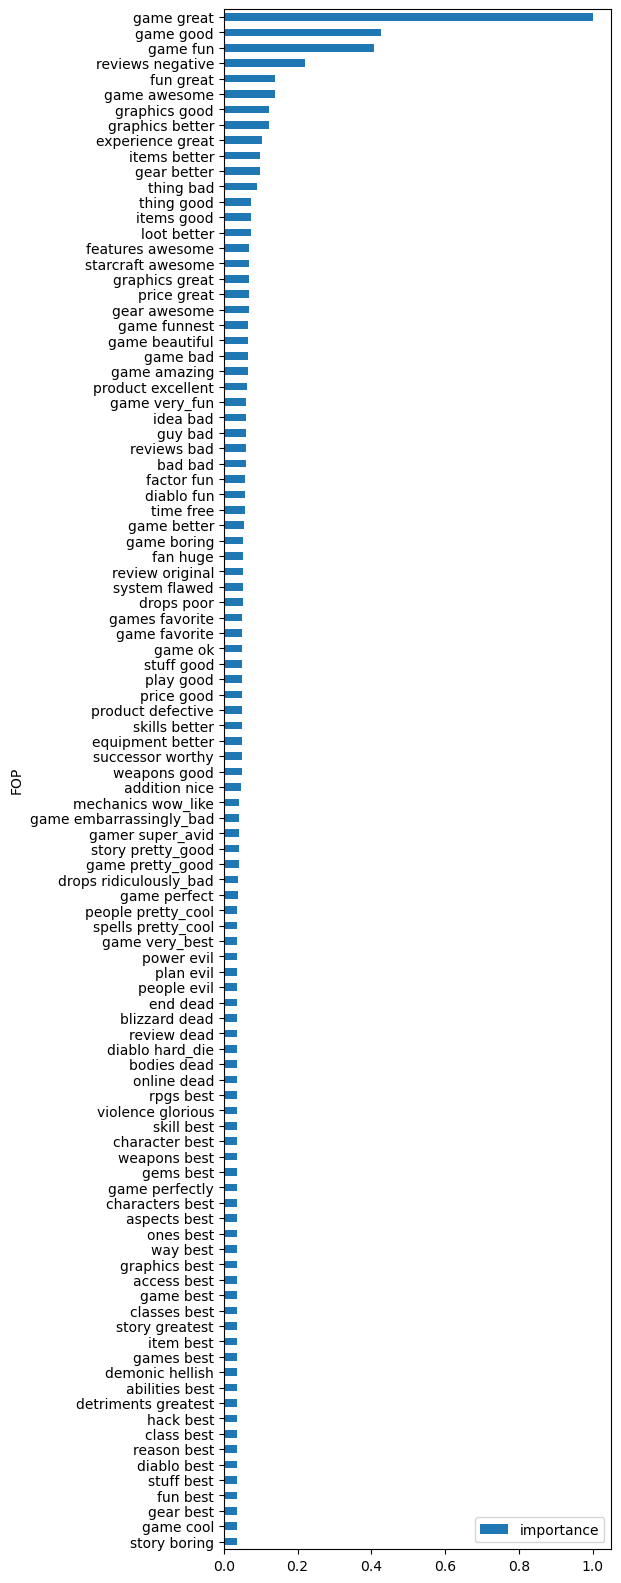

In [16]:
import matplotlib
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [5, 20]

FOPs_df = FOPs_df.sort_values('importance', ascending=False)
FOPs_df_top100 = FOPs_df.head(100)

ax = FOPs_df_top100.plot.barh(x='FOP', y = 'importance')
ax.invert_yaxis()
plt.show()

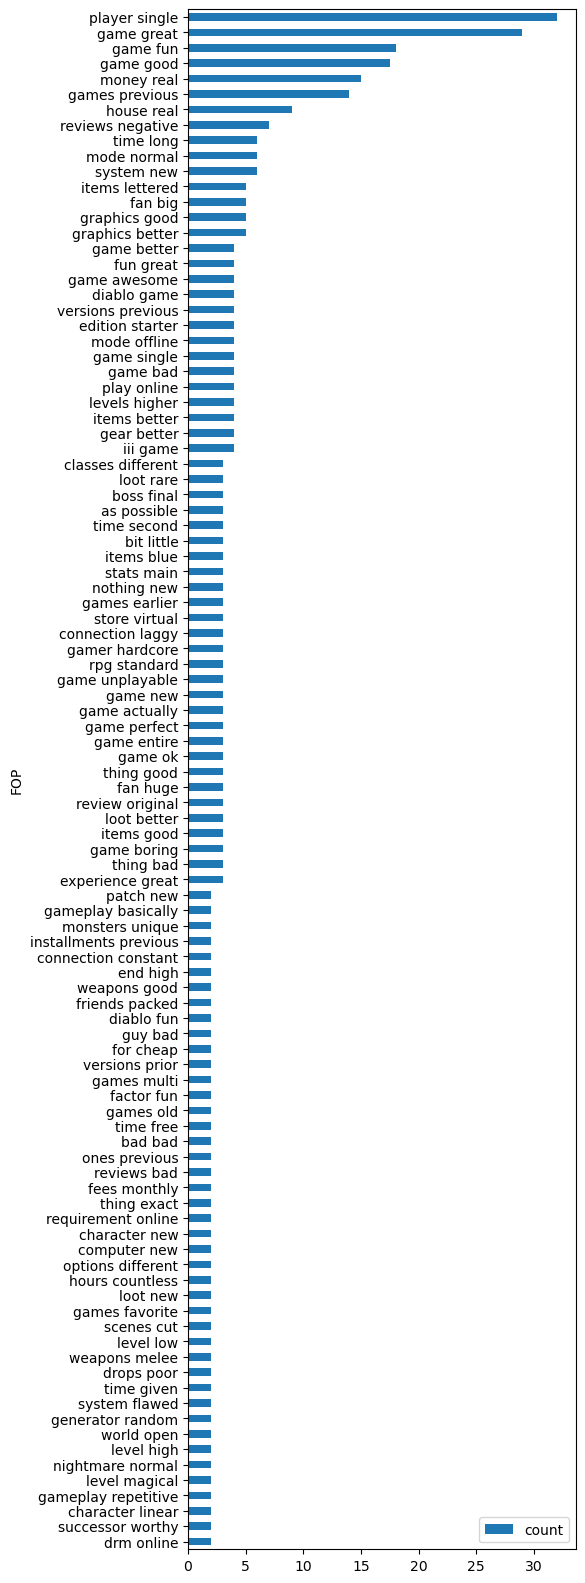

In [17]:
import matplotlib
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [5, 20]

FOPs_df = FOPs_df.sort_values('count', ascending=False)
FOPs_df_top100 = FOPs_df.head(100)

ax = FOPs_df_top100.plot.barh(x='FOP', y = 'count')
ax.invert_yaxis()
plt.show()

In [18]:
aggregation_functions = {'count':'sum', 'importance':'sum', 'feature':'first'}
FOPs_df_new = FOPs_df.groupby(FOPs_df['feature']).aggregate(aggregation_functions)

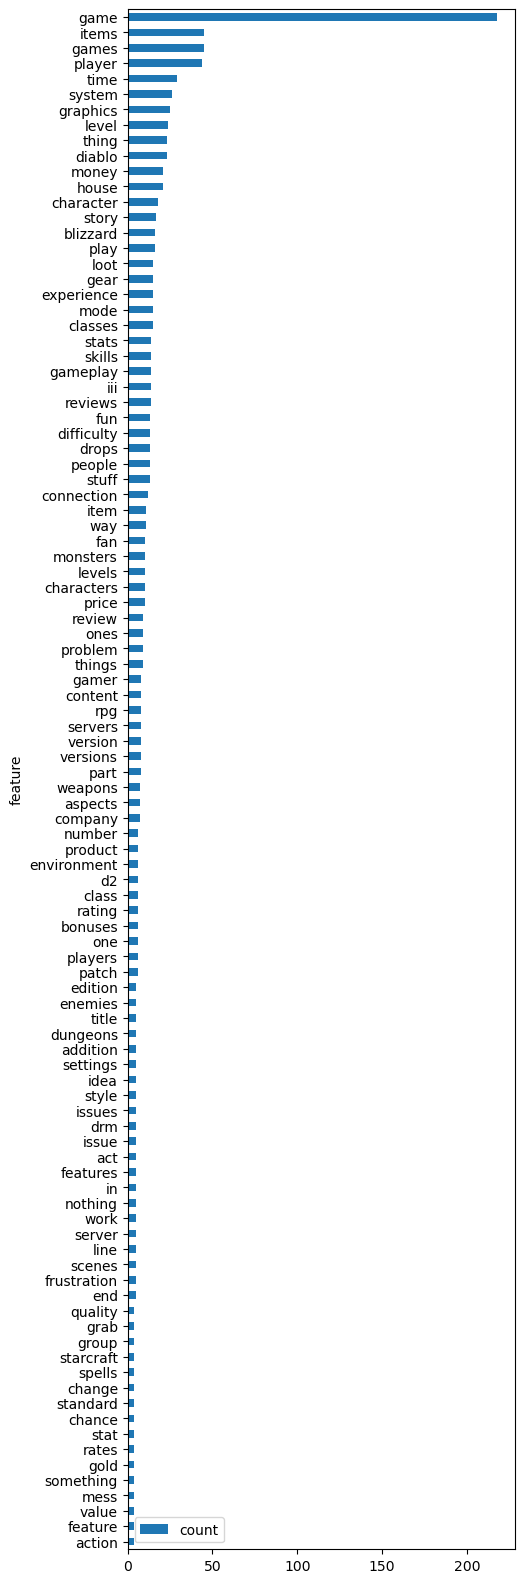

In [19]:
import matplotlib
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [5, 20]

FOPs_df_new = FOPs_df_new.sort_values('count', ascending=False)
FOPs_df_new_top100 = FOPs_df_new.head(100)

ax = FOPs_df_new_top100.plot.barh(x='feature', y = 'count')
ax.invert_yaxis()
plt.show()

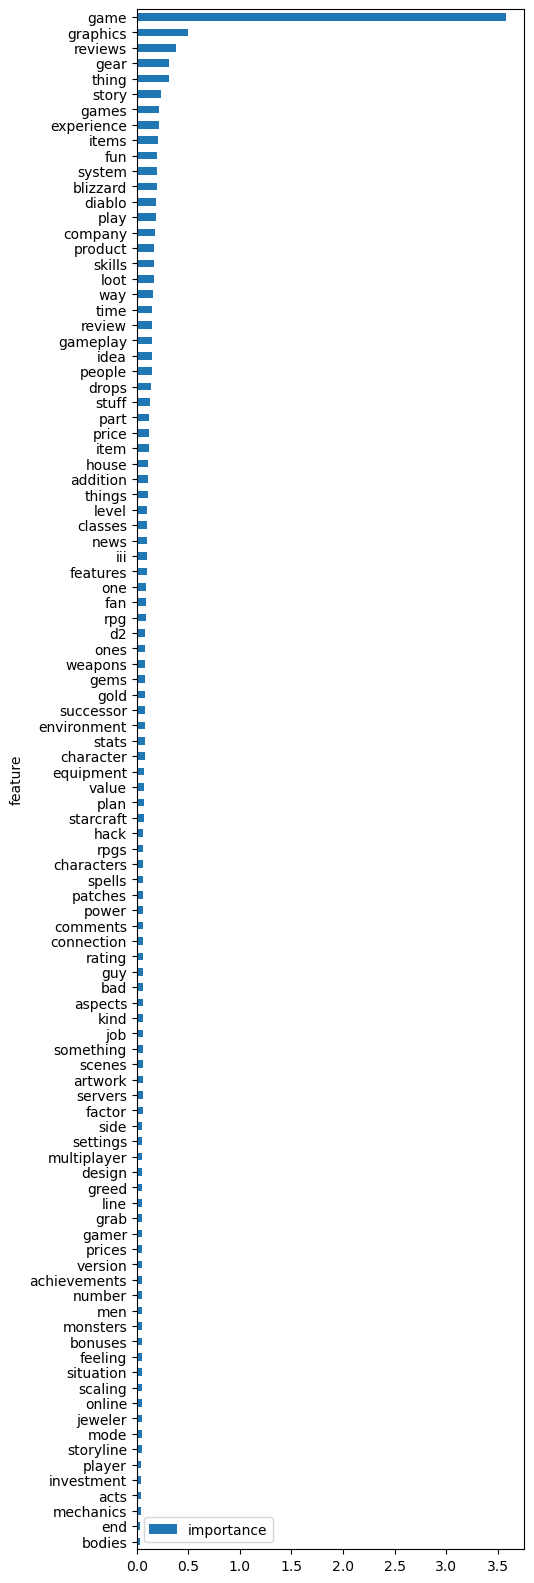

In [20]:
import matplotlib
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [5, 20]

FOPs_df_new = FOPs_df_new.sort_values('importance', ascending=False)
FOPs_df_new_top100 = FOPs_df_new.head(100)

ax = FOPs_df_new_top100.plot.barh(x='feature', y = 'importance')
ax.invert_yaxis()
plt.show()